In [109]:
import pandas as pd 
import numpy as np
df = pd.read_csv('C:/Users/kaczm/Downloads/housing.csv')
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [110]:
# going to locate the place based on long and lat
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geoapiExercises")
df['city'] = np.nan
for index, row in df.iterrows():
    location = geolocator.reverse(str(row['latitude'])+','+str(row['longitude']))
    address = location.raw['address']
    df.loc[index,'city'] = address.get('city')

# turns out the algorithm only found accurate geolocation data for ~65% entries which is not enough

KeyboardInterrupt: 

In [111]:
# X.to_csv('House_Prices.csv')
import pandas as pd
housing = pd.read_csv('C:/Users/kaczm/Downloads/House_Prices.csv')

In [112]:
# let's start exploring the data

housing.describe()

Unnamed: 0     longitude      latitude  housing_median_age  \
count  20640.000000  20640.000000  20640.000000        20640.000000   
mean   10319.500000   -119.569704     35.631861           28.639486   
std     5958.399114      2.003532      2.135952           12.585558   
min        0.000000   -124.350000     32.540000            1.000000   
25%     5159.750000   -121.800000     33.930000           18.000000   
50%    10319.500000   -118.490000     34.260000           29.000000   
75%    15479.250000   -118.010000     37.710000           37.000000   
max    20639.000000   -114.310000     41.950000           52.000000   

        total_rooms  total_bedrooms    population    households  \
count  20640.000000    20433.000000  20640.000000  20640.000000   
mean    2635.763081      537.870553   1425.476744    499.539680   
std     2181.615252      421.385070   1132.462122    382.329753   
min        2.000000        1.000000      3.000000      1.000000   
25%     1447.750000      296.000000    787.000000    280.000000   
50%     2127.000000      435.000000   1166.000000    409.000000   
75%     3148.000000      647.000000   1725.000000    605.000000   
max    39320.000000     6445.000000  35682.000000   6082.000000   

       median_income  median_house_value  
count   20640.000000        20640.000000  
mean        3.870671       206855.816909  
std         1.899822       115395.615874  
min         0.499900        14999.000000  
25%         2.563400       119600.000000  
50%         3.534800       179700.000000  
75%         4.743250       264725.000000  
max        15.000100       500001.000000

In [113]:
import plotly.express as px

# let's see how the house prices look like
fig = px.box(housing, y = 'median_house_value')
fig.update_layout(title='Median House Value')
fig.show()

In [114]:
# take a look at the histograms
housing.drop(columns = housing.columns[[0]], inplace = True )
housing.hist(bins = 40, figsize = (15,15) )

# seems like most houses lie around the -118 longitude and 34 latitude

array([[<AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'latitude'}>,
        <AxesSubplot: title={'center': 'housing_median_age'}>],
       [<AxesSubplot: title={'center': 'total_rooms'}>,
        <AxesSubplot: title={'center': 'total_bedrooms'}>,
        <AxesSubplot: title={'center': 'population'}>],
       [<AxesSubplot: title={'center': 'households'}>,
        <AxesSubplot: title={'center': 'median_income'}>,
        <AxesSubplot: title={'center': 'median_house_value'}>]],
      dtype=object)

In [115]:
# check out null values as well

housing.isnull().sum()

# we have 207 null values for total bedrooms and 8895 missing values for cities; seems like the geolocator couldn't match all the data
# we are gonna delete the null values for total bedrooms but we cannot really ignore 9000 rows of data; we will deal with the other data points
# using some classifier to assign cities to them

housing['city'].fillna('To be determined',inplace = True)
housing = housing.dropna()

In [116]:
# before we go into classifying the cities, first also take a look at the ocean proximity and house prices correlation

px.histogram(housing, x = 'median_house_value', facet_col = 'ocean_proximity', color = 'ocean_proximity', facet_col_wrap = 2).update_yaxes(matches=None, showticklabels=True)

# ok, so basically near ocean houses and near bay houses are more equally spread in terms of price and inland houses are the cheapest ones

In [117]:
fig = px.bar(housing, x = 'ocean_proximity', y = 'median_house_value', color = 'ocean_proximity',
             labels={'ocean_proximity':'Ocean Proximity', 'median_house_value':'Median House Value'},
             height=400)

fig.update_layout(title='Median House Value by Ocean Proximity',
                  title_font=dict(size=24, family='Arial, sans-serif', color='black'),
                  xaxis_title='Ocean Proximity', xaxis_title_font=dict(size=18, family='Arial, sans-serif', color='black'),
                  yaxis_title='Median House Value', yaxis_title_font=dict(size=18, family='Arial, sans-serif', color='black'))
fig.show()

# we can also see that most house come from areas <1H Ocean and inland

In [118]:
# one issue found so far relates to median income; we can see that the values have problably been standardized before and are in range (0,15)
# I will now set aside training data 
from sklearn.model_selection import train_test_split
X = housing.iloc[:,:-1]
y = housing.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 20)

In [119]:
len(X_train), len(X_test)
# 14303 rows of training data, 6130 of test data

# now maybe have a further look at the long and lat data

px.scatter(housing, x ='longitude', y ='latitude')

#plotly express scatter does not show us what we need - which is intensity of spread within the dataset. We need to use alpha to achieve
# a better visualization

housing.plot(kind = 'scatter', x='longitude', y='latitude', alpha=0.2)

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

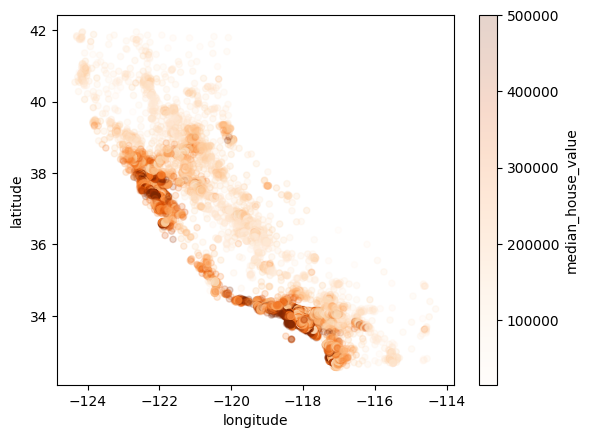

In [120]:
# now it would be best to see the median house prices set on those datapoints. I will try to create a chart visualizing that

housing.plot(kind = 'scatter', x='longitude', y='latitude', c = 'median_house_value', cmap = 'Oranges', alpha=0.2)

# ok, so now we see even more vividly that certain areas = higher house prices

<AxesSubplot: xlabel='median_income', ylabel='median_house_value'>

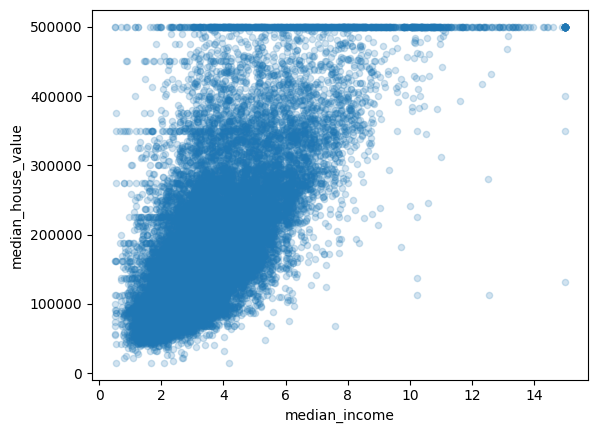

In [121]:
# it  would also be great to see how median income and median house value play out together

housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.2)

# as expected, the higher the income, the higher the house value

In [122]:
# check out other correlations - gonna use pearson as the values seem to generally resemble normal distribution

housing.corr(method = 'pearson')['median_house_value']

# ok, so median income is the only clearly correlated value


C:\Users\kaczm\AppData\Local\Temp\ipykernel_19544\3616719343.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



longitude            -0.045398
latitude             -0.144638
housing_median_age    0.106432
total_rooms           0.133294
total_bedrooms        0.049686
population           -0.025300
households            0.064894
median_income         0.688355
median_house_value    1.000000
Name: median_house_value, dtype: float64

In [123]:
# it's also worth noticing that while we have columns like total_rooms, population etc, we do not have averages of that (so avergae total_bedroo
# ms per district for example)

housing['average_bedroom_number'] = housing['total_bedrooms']/housing['households']
housing['average_room_number'] = housing['total_rooms']/housing['households']
housing['people_per_household'] = housing['population']/housing['households']

housing

# now with this data it could be useful to visualize data again



longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                  41          880           129.0   
1        -122.22     37.86                  21         7099          1106.0   
2        -122.24     37.85                  52         1467           190.0   
3        -122.25     37.85                  52         1274           235.0   
4        -122.25     37.85                  52         1627           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                  25         1665           374.0   
20636    -121.21     39.49                  18          697           150.0   
20637    -121.22     39.43                  17         2254           485.0   
20638    -121.32     39.43                  18         1860           409.0   
20639    -121.24     39.37                  16         2785           616.0   

       population  households  median_income ocean_proximity  \
0             322         126         8.3252        NEAR BAY   
1            2401        1138         8.3014        NEAR BAY   
2             496         177         7.2574        NEAR BAY   
3             558         219         5.6431        NEAR BAY   
4             565         259         3.8462        NEAR BAY   
...           ...         ...            ...             ...   
20635         845         330         1.5603          INLAND   
20636         356         114         2.5568          INLAND   
20637        1007         433         1.7000          INLAND   
20638         741         349         1.8672          INLAND   
20639        1387         530         2.3886          INLAND   

                   city  median_house_value  average_bedroom_number  \
0               Oakland              452600                1.023810   
1               Oakland              358500                0.971880   
2               Oakland              352100                1.073446   
3               Oakland              341300                1.073059   
4               Oakland              342200                1.081081   
...                 ...                 ...                     ...   
20635  To be determined               78100                1.133333   
20636  To be determined               77100                1.315789   
20637  To be determined               92300                1.120092   
20638  To be determined               84700                1.171920   
20639  To be determined               89400                1.162264   

       average_room_number  people_per_household  
0                 6.984127              2.555556  
1                 6.238137              2.109842  
2                 8.288136              2.802260  
3                 5.817352              2.547945  
4                 6.281853              2.181467  
...                    ...                   ...  
20635             5.045455              2.560606  
20636             6.114035              3.122807  
20637             5.205543              2.325635  
20638             5.329513              2.123209  
20639             5.254717              2.616981  

[20433 rows x 14 columns]

In [124]:
fig = px.scatter(housing, x = 'people_per_household', y = 'median_house_value',
                 title = 'Median House Value vs People per Household', # Adding title
                 labels = {'people_per_household':'People per Household', 'median_house_value':'Median House Value'}, # renaming the axis labels
                 range_x = [0,10], # setting the range of x-axis
                 range_y = [0,500000], # setting the range of y-axis
                 template = 'plotly_dark', # using dark theme
                 size = 'population', # size of the dots based on population
                 color = 'ocean_proximity', # color of the dots based on ocean proximity
                 marginal_x = 'histogram', # showing histogram on x-axis
                 marginal_y = 'box') # showing box plot on y-axis

fig.show()

# interesting, seems like the more people per household, the cheaper the house

In [125]:
px.scatter(housing, x = 'average_bedroom_number', y = 'median_house_value').update_xaxes(range = [0,10])

In [126]:


fig = px.scatter(housing, x = 'average_room_number', y = 'median_house_value',
                 title = 'Median House Value vs Average Room Number', # Adding title
                 labels = {'average_room_number':'Average Room Number', 'median_house_value':'Median House Value'}, # renaming the axis labels
                 range_x = [0,10], # setting the range of x-axis
                 range_y = [0,500000], # setting the range of y-axis
                 template = 'plotly_dark', # using dark theme
                 size = 'population', # size of the dots based on population
                 color = 'ocean_proximity', # color of the dots based on ocean proximity
                 marginal_x = 'histogram', # showing histogram on x-axis
                 marginal_y = 'box') # showing box plot on y-axis

fig.show()

# very interesting - seems like more bedrooms != lesser prices, but more rooms =  higher price
# it's in line with what we observed about the number of persons per household; bigger families may not mean more expensive house

In [127]:
# checking the correlation matrix again
housing.corr(method = 'pearson')['median_house_value']

C:\Users\kaczm\AppData\Local\Temp\ipykernel_19544\1010523979.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



longitude                -0.045398
latitude                 -0.144638
housing_median_age        0.106432
total_rooms               0.133294
total_bedrooms            0.049686
population               -0.025300
households                0.064894
median_income             0.688355
median_house_value        1.000000
average_bedroom_number   -0.046739
average_room_number       0.151344
people_per_household     -0.023639
Name: median_house_value, dtype: float64

In [128]:
# now we really need to assign proper cities to the missing values; we are gonna use the kNN algorithm for that

df_for_city = housing.loc[:,['longitude','latitude','city']]
df_for_city = df_for_city.loc[df_for_city['city'] != 'To be determined']
df_for_city

longitude  latitude         city
0        -122.23     37.88      Oakland
1        -122.22     37.86      Oakland
2        -122.24     37.85      Oakland
3        -122.25     37.85      Oakland
4        -122.25     37.85      Oakland
...          ...       ...          ...
20503    -118.75     34.33  Simi Valley
20504    -118.73     34.29  Simi Valley
20505    -118.72     34.29  Simi Valley
20506    -118.73     34.29  Simi Valley
20523    -121.55     38.51   Sacramento

[11622 rows x 3 columns]

In [129]:
# lets train the model

from sklearn.model_selection import train_test_split

y = df_for_city.pop('city')


In [130]:
y = y.astype(str)


In [131]:
X = df_for_city
X = X.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

from sklearn.neighbors import KNeighborsClassifier 

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [132]:
from sklearn.metrics import mean_squared_error
from math import sqrt

test_preds = knn_model.predict(X_test)


In [133]:
# confusion matrix to evaluate

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, test_preds)

array([[54,  0,  0, ...,  0,  0,  0],
       [ 0,  7,  0, ...,  0,  0,  0],
       [ 0,  0, 45, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 19,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  3]], dtype=int64)

In [136]:
# let's check recall and f1-score

from sklearn.metrics import recall_score, f1_score

recall = recall_score(y_test, test_preds, average = 'macro')
print(recall)

# Calculate f1-score
f1 = f1_score(y_test, test_preds, average = 'macro')
print(f1)

0.8703944133752032
0.8643933541057403


c:\Users\kaczm\.virtualenvs\python_prj-SRynVlFM\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [137]:
#let's assess the model further
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_preds)

# 98% accuracy is a really good score

0.9784915400057356

In [138]:
# now let's predict the missing values

df_city_predict  = housing.loc[:,['longitude','latitude','city']]
df_city_predict = df_city_predict.loc[df_city_predict['city'] == 'To be determined']

df_city_predict = df_city_predict.iloc[:,:-1]
cities_predicted = knn_model.predict(df_city_predict)





In [139]:
# merging predicted cities with the long/lat columns

cities_predicted_df = pd.DataFrame(cities_predicted, columns = ['city'], index = df_city_predict.index)

housing = housing.merge(cities_predicted_df, how ='outer', left_on = housing.index, right_on = cities_predicted_df.index)


In [140]:
housing.drop(columns = ['key_0'], inplace = True)

for index, row in housing.iterrows():
    if housing.loc[index, 'city_x'] == 'To be determined':
        housing.loc[index, 'city_x'] = housing.loc[index, 'city_y']

housing        

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                  41          880           129.0   
1        -122.22     37.86                  21         7099          1106.0   
2        -122.24     37.85                  52         1467           190.0   
3        -122.25     37.85                  52         1274           235.0   
4        -122.25     37.85                  52         1627           280.0   
...          ...       ...                 ...          ...             ...   
20428    -121.09     39.48                  25         1665           374.0   
20429    -121.21     39.49                  18          697           150.0   
20430    -121.22     39.43                  17         2254           485.0   
20431    -121.32     39.43                  18         1860           409.0   
20432    -121.24     39.37                  16         2785           616.0   

       population  households  median_income ocean_proximity     city_x  \
0             322         126         8.3252        NEAR BAY    Oakland   
1            2401        1138         8.3014        NEAR BAY    Oakland   
2             496         177         7.2574        NEAR BAY    Oakland   
3             558         219         5.6431        NEAR BAY    Oakland   
4             565         259         3.8462        NEAR BAY    Oakland   
...           ...         ...            ...             ...        ...   
20428         845         330         1.5603          INLAND  Yuba City   
20429         356         114         2.5568          INLAND  Yuba City   
20430        1007         433         1.7000          INLAND  Yuba City   
20431         741         349         1.8672          INLAND  Yuba City   
20432        1387         530         2.3886          INLAND  Yuba City   

       median_house_value  average_bedroom_number  average_room_number  \
0                  452600                1.023810             6.984127   
1                  358500                0.971880             6.238137   
2                  352100                1.073446             8.288136   
3                  341300                1.073059             5.817352   
4                  342200                1.081081             6.281853   
...                   ...                     ...                  ...   
20428               78100                1.133333             5.045455   
20429               77100                1.315789             6.114035   
20430               92300                1.120092             5.205543   
20431               84700                1.171920             5.329513   
20432               89400                1.162264             5.254717   

       people_per_household     city_y  
0                  2.555556        NaN  
1                  2.109842        NaN  
2                  2.802260        NaN  
3                  2.547945        NaN  
4                  2.181467        NaN  
...                     ...        ...  
20428              2.560606  Yuba City  
20429              3.122807  Yuba City  
20430              2.325635  Yuba City  
20431              2.123209  Yuba City  
20432              2.616981  Yuba City  

[20433 rows x 15 columns]

In [141]:
# now we have a dataframe with information about the city as well
housing.drop(columns = 'city_y', inplace = True)
housing.rename(columns = {'city_x' : 'city'}, inplace = True)

# and 0 null values

In [142]:

# we now need to transform categorical variables

categorical_columns = housing.select_dtypes(include = ['object']).columns

# ocean proximity will be easier to deal with; it only has 4 unique values so we can encode binarily using one hot encoding

import category_encoders as ce

encoder = ce.OneHotEncoder(cols = ['ocean_proximity', 'city'], return_df=True, use_cat_names=True)

encoded_data = encoder.fit_transform(housing)



In [143]:
# now we should delete the columns with cities that only have a very small number of entries, let's assume that if a city occurs less than 100 times 
# it is deleted

df_for_try = encoded_data

for column in df_for_try.columns:
    if 'city' in column:
        if df_for_try[column].value_counts()[1] < 100:
            df_for_try = df_for_try.drop(columns = column)

df_for_try.shape

(20433, 81)

In [144]:
# as i am gonna use random forest, standardization/ normalization is not required 
# let's start creating the model

y =  df_for_try.pop('median_house_value')


In [145]:
X =  df_for_try

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators= 500, random_state=13)

# using 1000 trees for better performance, then used 2000, then 500 but the outcome stays basically the same

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=13)

In [146]:
# predicting 

predictions = rf.predict(X_test)

In [147]:
# check absolute error
import numpy as np 

abs_err = abs(predictions - y_test)
np.mean(abs_err)

# 32k is a significant, but not tragic absolute error, so I'm tweaking the numbers

31867.32757095322

In [148]:
 # Calculate mean absolute percentage error (MAPE)

mape = 100 * (abs_err / y_test)
accuracy = 100 - np.mean(mape)

accuracy

# accuracy of 82% 

82.84158820065396

In [149]:
# i am gonna use cross validation to make sure the outcomes are not biased by how training and test sets are separated

from sklearn.model_selection import cross_val_score

rf_set = RandomForestRegressor(n_estimators= 500, random_state=13)
scores = cross_val_score(rf_set, X, y, cv=5)
scores

array([0.50887212, 0.64708392, 0.73273501, 0.50266673, 0.72417492])

In [150]:
forest_scores = np.sqrt(-scores)
forest_scores.mean()

C:\Users\kaczm\AppData\Local\Temp\ipykernel_19544\757273853.py:1: RuntimeWarning:

invalid value encountered in sqrt



nan

In [151]:
# let's also check root mean squared error
import math

MSE = np.square(np.subtract(y_test,predictions)).mean() 
RMSE = math.sqrt(MSE)
RMSE

# RMSE of 49005 



49139.52206446626

In [152]:
# i am going to try and tweak hyperparameters to find the best fit using gridsearch

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3, 10, 30,100,200, 500], 'max_features': [2, 4, 6, 8]},  
    {'bootstrap': [False], 'n_estimators':[3, 10, 50, 150], 'max_features': [2, 3, 4]},  
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose = 4)  # each model is trained 5 times, so (12+6)*5 = 80 rounds of training in total
grid_search.fit(X_train, y_train)
grid_search.best_params_  # best parameters

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END max_features=2, n_estimators=3;, score=-4510460932.237 total time=   0.0s
[CV 2/5] END max_features=2, n_estimators=3;, score=-4038250956.041 total time=   0.0s
[CV 3/5] END max_features=2, n_estimators=3;, score=-4212054104.722 total time=   0.0s
[CV 4/5] END max_features=2, n_estimators=3;, score=-4204729647.741 total time=   0.0s
[CV 5/5] END max_features=2, n_estimators=3;, score=-4269476994.230 total time=   0.0s
[CV 1/5] END max_features=2, n_estimators=10;, score=-3014711561.384 total time=   0.2s
[CV 2/5] END max_features=2, n_estimators=10;, score=-3106157986.550 total time=   0.2s
[CV 3/5] END max_features=2, n_estimators=10;, score=-2965322823.945 total time=   0.2s
[CV 4/5] END max_features=2, n_estimators=10;, score=-3258523571.377 total time=   0.2s
[CV 5/5] END max_features=2, n_estimators=10;, score=-3166172678.609 total time=   0.2s
[CV 1/5] END max_features=2, n_estimators=30;, score=-265137808

{'max_features': 8, 'n_estimators': 500}

In [153]:
grid_search.best_estimator_  # best estimators

RandomForestRegressor(max_features=8, n_estimators=500)

In [154]:
# checking the importance of the features

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.99817287e-02, 8.00045550e-02, 3.63741637e-02, 3.26330093e-02,
       2.56206201e-02, 3.09307160e-02, 2.51469298e-02, 2.36092361e-01,
       7.85181467e-03, 2.54893901e-02, 1.01588365e-01, 1.12047629e-02,
       6.11395521e-05, 2.70360806e-03, 6.72374152e-04, 9.18221657e-04,
       9.51740711e-04, 1.01134616e-03, 1.97664546e-04, 1.87253679e-04,
       1.37392414e-04, 4.49592980e-04, 6.23537471e-04, 4.43034707e-04,
       1.32118696e-03, 2.61896656e-03, 3.16000623e-04, 2.49931739e-04,
       4.42116246e-03, 1.42044181e-04, 5.01081934e-04, 2.21306052e-03,
       4.96701992e-04, 8.07009584e-04, 9.92976241e-04, 1.08881493e-02,
       4.27679087e-03, 5.38655953e-04, 7.00138116e-03, 4.15083336e-04,
       3.53208129e-04, 3.36831267e-03, 4.70217559e-04, 1.87185973e-04,
       1.74742632e-04, 2.55843371e-04, 1.17328704e-03, 6.92994913e-04,
       2.77824180e-03, 1.63454350e-02, 4.19551737e-04, 5.93467705e-04,
       7.80931061e-04, 2.11636112e-03, 6.69595777e-04, 2.67212219e-04,
      

In [155]:
attributes = df_for_try.columns
sorted(zip(feature_importances, attributes), reverse=True)

# seems like most of the cities variables except for San Francisco and LA are not useful at all, same goes to ocean_proximity near bay and near ocean
# they could be removed from the model if we wanted to

[(0.23609236117577478, 'median_income'),
 (0.1015883647743148, 'ocean_proximity_INLAND'),
 (0.09806748347379778, 'average_room_number'),
 (0.08000455498853108, 'latitude'),
 (0.07998172865238998, 'longitude'),
 (0.07955976870414992, 'people_per_household'),
 (0.03637416373447025, 'housing_median_age'),
 (0.032633009330005736, 'total_rooms'),
 (0.03093071603305312, 'population'),
 (0.029391935152344246, 'average_bedroom_number'),
 (0.025620620141797324, 'total_bedrooms'),
 (0.025489390148254378, 'ocean_proximity_<1H OCEAN'),
 (0.025146929844320435, 'households'),
 (0.016345435032262576, 'city_San Francisco'),
 (0.011204762942057632, 'ocean_proximity_NEAR OCEAN'),
 (0.010888149339793063, 'city_Los Angeles'),
 (0.007851814666998715, 'ocean_proximity_NEAR BAY'),
 (0.007001381155344442, 'city_Torrance'),
 (0.004421162461198416, 'city_Fresno'),
 (0.004276790869186412, 'city_Pasadena'),
 (0.0035162953309719586, 'city_San Mateo'),
 (0.003368312671680068, 'city_El Monte'),
 (0.00302255305704743

In [156]:
# checking the final outcome with tweaked parameters
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)

final_rmse = np.sqrt(final_mse)

final_rmse

# the score is better than the one tweaked by myself by almost 1500

48175.72405877599

In [157]:
abs_err_test = abs(final_predictions - y_test)
np.mean(abs_err_test)

32114.433976512035

In [158]:
mape_test = 100 * (abs_err_test / y_test)
accuracy_test = 100 - np.mean(mape_test)

accuracy_test

82.36582050610396